### To Do
- Rerun case 2-5
- Fix postcodes
- Sort out end date window
- Check sensistive columns
- Get our approved model on the site

In [1]:
import sys
import pandas as pd
import pickle
sys.path.append('../twc_api/')
import boto3
import json
from tqdm import tqdm_notebook

from api.resources.retrain import construct_full_tables, train_model_from_json, split_train_test
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
session = boto3.Session(profile_name='twc')
s3 = session.resource('s3')

In [3]:
from api.utils.transformers import *
from api.utils.aws import *

In [4]:
from scipy.stats import spearmanr
from sklearn.ensemble import ExtraTreesRegressor

### Case 1:
#### DB Data ---> Notebook transforms ---> Notebook train ---> Notebook evaluate

##### Generate Data from Database

In [7]:
generator = TrainingDataGenerator('../../Welcome-Centre-DataCorps-Data/ClientDatabaseStructure.mdb.sqlite')
tables_from_db = generator.get_training_data(limit=100000)

##### Build X, y , referral table

In [8]:
features_to_split = []

transformer = TransformerPipeline([
                        ConsolidateTablesTransformer(count_encode=False),
                        AddFutureReferralTargetFeatures(),
                        TimeFeatureTransformer(break_length=28),
                        SplitCurrentAndEverTransformer(['referralissue_', 
                                                       'referraldomesticcircumstances_',
                                                        'referralreason_', 'referralbenefit_'])
                                    ], aligner=AlignFeaturesToColumnSchemaTransformer())

X1, y1, referral_table_1 = transformer.fit_transform(tables_from_db)

##### Check Dimensions of X, y

In [12]:
print('Shape X:{}, Shape y: {}'.format(X1.shape, y1.shape))

Shape X:(17980, 574), Shape y: (17980,)


##### Split out Train and Test

In [13]:
train_test_split = 0.75
train_index = int(train_test_split*len(X1))
X1_train = X1.iloc[:13485]
X1_test = X1.iloc[13485:]
y1_train = y1.loc[X1_train.index]
y1_test = y1.loc[X1_test.index]

##### Build a model

In [14]:
et = ExtraTreesRegressor(n_jobs=-1, n_estimators=500)
et.fit(X1_train, y1_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

##### Evaluate Model

In [15]:
def get_scores_per_window(x, y, group, threshold=0.2):
    corr = spearmanr(x, y)[0]
    mu_a = x.groupby(group).mean()
    mu_p = y.groupby(group).mean()
    mu_a_top = mu_a[mu_a.rank(ascending=False) / len(mu_a) < threshold]
    mu_p_top = mu_p[mu_p.rank(ascending=False) / len(mu_p) < threshold]
    overlap = mu_p_top.index.isin(mu_a_top.index).mean()
    return pd.Series([corr, overlap], index=['spearman', 'overlap'])

def evaluate_average_weekly_rank_correlation(test_referral_table, y_test, y_pred):
    grouped_y = test_referral_table.assign(y=y_test, pred=y_pred).set_index('referral_referraltakendate')\
        .groupby([pd.TimeGrouper('1W'), 'client_clientid'])['y'].mean()
    grouped_pred_y = test_referral_table.assign(y=y_test, pred=y_pred).set_index('referral_referraltakendate')\
        .groupby([pd.TimeGrouper('1W'), 'client_clientid'])['pred'].mean()
    time_grouped = pd.concat([grouped_y, grouped_pred_y], axis=1)
    return time_grouped.reset_index().groupby(['referral_referraltakendate']).\
        apply(lambda k: get_scores_per_window(k['y'], k['pred'], k['client_clientid'])).dropna().mean()

In [16]:
y1_pred = pd.Series(et.predict(X1_test), X1_test.index)
test_referral_table = referral_table_1.loc[X1_test.index]
evaluate_average_weekly_rank_correlation(test_referral_table, y1_test, y1_pred)

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  # This is added back by InteractiveShellApp.init_path()
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if sys.path[0] == '':
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)

spearman    0.496957
overlap     0.531628
dtype: float64

### Case 2
##### DB Data --> JSON ---> Notebook transforms ---> Notebook train ---> Notebook evaluate

In [200]:
def make_tables_new_format(things):
    return_list = []
    for client_id in tqdm_notebook(unique_ids):
        client_dict = {}
        for k in things:
            if 'clientid' in things[k]:
                segment = things[k][things[k]['clientid'] == client_id]
            else:
                referral_instance_ids = referrals_per_client[referrals_per_client['clientid']==client_id]['referralinstanceid']
                segment = things[k][things[k]['referralinstanceid'].isin(referral_instance_ids)]
            if len(segment) > 0:
                client_dict[k] = segment.to_dict(orient='records')
            else:
                client_dict[k] = []
        return_list.append(client_dict)
    return return_list

In [201]:
unique_ids = tables_from_db['client']['clientid'].unique()
referrals_per_client = tables_from_db['referral']
db_tables_as_json = make_tables_new_format(tables_from_db)

HBox(children=(IntProgress(value=0, max=5691), HTML(value='')))

In [202]:
tables_from_json_from_db = construct_full_tables(db_tables_as_json)

In [203]:
X2, y2, referral_table_2 = transformer.fit_transform(tables_from_json_from_db)

X2 = X2.fillna(0)

In [204]:
print('Shape X:{}, Shape y: {}'.format(X2.shape, y2.shape))

Shape X:(17980, 593), Shape y: (17980,)


##### Build Model and Evaluate

In [205]:
X2_train = X2[X2.index < 13500]
X2_test = X2[X2.index >= 13500]
y2_train = y2.loc[X2_train.index]
y2_test = y2.loc[X2_test.index]

In [206]:
et2 = ExtraTreesRegressor(n_jobs=-1, n_estimators=500)
et2.fit(X2_train, y2_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [207]:
y2_pred = pd.Series(et2.predict(X2_test), X2_test.index)
test_referral_table = referral_table_2.loc[X2_test.index]
evaluate_average_weekly_rank_correlation(test_referral_table, y2_test, y2_pred)

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  # This is added back by InteractiveShellApp.init_path()
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if sys.path[0] == '':
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)

spearman    0.499739
overlap     0.541078
dtype: float64

### Case 3
##### DB Data --> JSON ---> Library transforms ---> Library train ---> Notebook Evaluate

In [231]:
X3, y3, referral_table_3, et3, message = train_model_from_json(db_tables_as_json)

../twc_api/api/utils/evaluate.py:16: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  .groupby([pd.TimeGrouper('1W'), 'client_clientid'])['y']\
../twc_api/api/utils/evaluate.py:20: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  .groupby([pd.TimeGrouper('1W'), 'client_clientid'])['pred']\
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages

In [232]:
print(message)

Features Matrix generated consisting of 17980 referrals and 593 features
Train/Test sets split.
Train set: 13484 referrals.
Test set: 4496 referrals
Trained Model on: 13484 observations
Model Test Evaluation Metrics:
	Test Set Correlation of Predicted and Actual Mean Weekly Scores: 0.496771412117872
	Test Set Overlap of top 20.0% worst cases: 0.5275197446421702


In [211]:
y3_pred = pd.Series(et3.predict(X3_test), X3_test.index)
test_referral_table = referral_table_2.loc[X3_test.index]
evaluate_average_weekly_rank_correlation(test_referral_table, y3_test, y3_pred)

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  # This is added back by InteractiveShellApp.init_path()
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if sys.path[0] == '':
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)

spearman    0.498597
overlap     0.538726
dtype: float64

### Case 4
##### Andrew JSON Data --> Library Transforms --> Library Train --> Library Evaluate

In [17]:
with open('../twc_api/api/requestNewData.json', 'r') as f:
    andrew_json_data = json.load(f)

In [18]:
X4, y4, referral_table4, et4, message4 = train_model_from_json(andrew_json_data)

../twc_api/api/utils/evaluate.py:16: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  .groupby([pd.TimeGrouper('1W'), 'client_clientid'])['y']\
../twc_api/api/utils/evaluate.py:20: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  .groupby([pd.TimeGrouper('1W'), 'client_clientid'])['pred']\


In [20]:
print(message4)

Features Matrix generated consisting of 21079 referrals and 565 features
Train/Test sets split.
Train set: 15808 referrals.
Test set: 5271 referrals
Trained Model on: 15808 observations
Model Test Evaluation Metrics:
	Test Set Correlation of Predicted and Actual Mean Weekly Scores: 0.4472522800116791
	Test Set Overlap of top 20.0% worst cases: 0.43475828644035014


### Case 5
##### Newest Andrew JSON Data (sent 3rd August 2018) --> Library Transforms --> Library Train --> Library Evaluate

In [24]:
with open('../twc_api/api/JSONExport20180803200350.JSON', 'r') as f:
    aug_andrew_json_data = json.load(f)

In [27]:
X5, y5, referral_table5, et5, message5 = train_model_from_json(aug_andrew_json_data)

../twc_api/api/utils/evaluate.py:16: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  .groupby([pd.TimeGrouper('1W'), 'client_clientid'])['y']\
../twc_api/api/utils/evaluate.py:20: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  .groupby([pd.TimeGrouper('1W'), 'client_clientid'])['pred']\


In [28]:
print(message5)

Features Matrix generated consisting of 26592 referrals and 2588 features
Train/Test sets split.
Train set: 19943 referrals.
Test set: 6649 referrals
Trained Model on: 19943 observations
Model Test Evaluation Metrics:
	Test Set Correlation of Predicted and Actual Mean Weekly Scores: 0.45962503773357094
	Test Set Overlap of top 20.0% worst cases: 0.4622611842907768


In [31]:
print(list(X5.columns))

['referral_dependantnumber', 'referral_livingwithpartner', 'referral_referralpreparedworkerid', 'referraldietaryrequirements_1', 'referraldietaryrequirements_2', 'referraldietaryrequirements_3', 'referraldietaryrequirements_4', 'referraldietaryrequirements_5', 'referraldietaryrequirements_6', 'referraldietaryrequirements_7', 'referraldietaryrequirements_8', 'referraldietaryrequirements_9', 'referraldietaryrequirements_10', 'referraldietaryrequirements_11', 'referraldietaryrequirements_12', 'referraldocument_1', 'referraldocument_2', 'referraldocument_3', 'referraldocument_4', 'referraldocument_5', 'client_age', 'client_addresslength', 'client_clientismale', 'client_knownpartner', 'client_clientcountryid_1', 'client_clientcountryid_10', 'client_clientcountryid_11', 'client_clientcountryid_12', 'client_clientcountryid_13', 'client_clientcountryid_14', 'client_clientcountryid_15', 'client_clientcountryid_16', 'client_clientcountryid_17', 'client_clientcountryid_18', 'client_clientcountryi

In [32]:
print(list(X4.columns))

['referral_dependantnumber', 'referral_livingwithpartner', 'referral_referralpreparedworkerid', 'referraldietaryrequirements_1', 'referraldietaryrequirements_2', 'referraldietaryrequirements_3', 'referraldietaryrequirements_4', 'referraldietaryrequirements_5', 'referraldietaryrequirements_6', 'referraldietaryrequirements_7', 'referraldietaryrequirements_8', 'referraldietaryrequirements_9', 'referraldietaryrequirements_10', 'referraldietaryrequirements_11', 'referraldietaryrequirements_12', 'referraldocument_1', 'referraldocument_2', 'referraldocument_3', 'referraldocument_4', 'referraldocument_5', 'client_age', 'client_addresslength', 'client_clientismale', 'client_knownpartner', 'client_clientcountryid_1', 'client_clientcountryid_10', 'client_clientcountryid_11', 'client_clientcountryid_12', 'client_clientcountryid_13', 'client_clientcountryid_14', 'client_clientcountryid_15', 'client_clientcountryid_16', 'client_clientcountryid_17', 'client_clientcountryid_18', 'client_clientcountryi

In [221]:
y5_pred = pd.Series(et.predict(X5_test), X5_test.index)
test_referral_table_5 = referral_table_5.loc[X5_test.index]
evaluate_average_weekly_rank_correlation(test_referral_table_5, y5_test, y5_pred)

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  # This is added back by InteractiveShellApp.init_path()
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if sys.path[0] == '':


spearman    0.443379
overlap     0.423071
dtype: float64

In [236]:
t = split_train_test(X5, y5, referral_table_5, 0.2)[4]
t.referral_referraltakendate.diff().describe()

count                     16861
mean     0 days 02:28:23.970108
std      2 days 12:30:23.903882
min             0 days 00:00:00
25%             0 days 00:05:00
50%             0 days 00:12:00
75%             0 days 00:27:00
max           322 days 00:00:00
Name: referral_referraltakendate, dtype: object

In [238]:
X5.shape

(21079, 584)

In [239]:
X1.shape

(17980, 593)

In [243]:
referral_table_5.referral_referraltakendate.min()

Timestamp('2013-01-06 00:00:00')

In [245]:
referral_table_1.referral_referraltakendate.min()

Timestamp('2013-01-06 00:00:00')

In [248]:
new_data = referral_table_5.groupby(referral_table_5.referral_referraltakendate.dt.year).size()

In [249]:
old_data = referral_table_1.groupby(referral_table_1.referral_referraltakendate.dt.year).size()

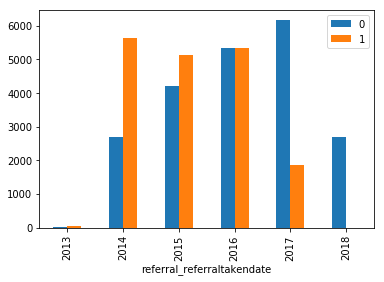

In [254]:
pd.concat([new_data, old_data], axis=1).plot(kind='bar')

In [255]:
new_data.sum() - old_data.sum()

3099

In [256]:
y5_train.mean()

0.06126116133325939

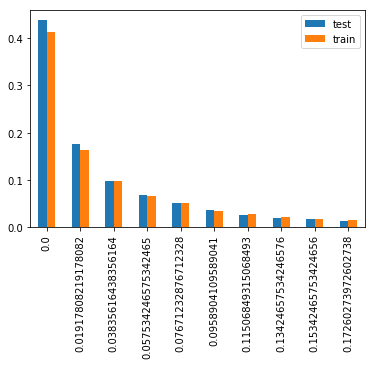

In [269]:
test_y = y5_test.value_counts(normalize=True)
train_y = y5_train.value_counts(normalize=True)
compare = pd.concat([test_y, train_y], axis=1).head(10)
compare.columns = ['test', 'train']
compare.plot(kind='bar')

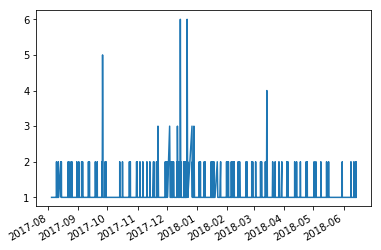

In [275]:
referral_table_5.loc[X5_test.index]['referral_referraltakendate'].value_counts().sort_index().plot()

In [259]:
y5_train.describe()

count    15808.000000
mean         0.061261
std          0.118984
min          0.000000
25%          0.000000
50%          0.019178
75%          0.076712
max          1.035616
Name: futurereferraltargetfeature_futurereferralscore, dtype: float64